## Hourly Time Stamp Deep Learning Analyse

##### Random Forest

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best CPC RF params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best K-means RF params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
    hour  n_samples   cpc_auc   cpc_acc    km_auc    km_acc
0      6         52  0.639881  0.729091  0.652116  0.463636
1      7         59  0.518981  0.710606  0.639686  0.575758
2      8         68  0.475985  0.691209  0.687133  0.426374
3      9         73  0.693939  0.754286  0.726364  0.549524
4     10         80  0.718750  0.712500  0.654289  0.487500
..   ...        ...       ...       ...       ...       ...
73    79        109  0.729118  0.844156  0.741545  0.615584
74    80        107  0.671321  0.841126  0.807339  0.673160
75    81        106  0.733796  0.859307  0.759272  0.612987
76    82        105  0.861547  0.866667  0.764180  0.552381
77    83        105  0.779902  0.828571  0.764243  0.600000

[78 rows x 6 columns]


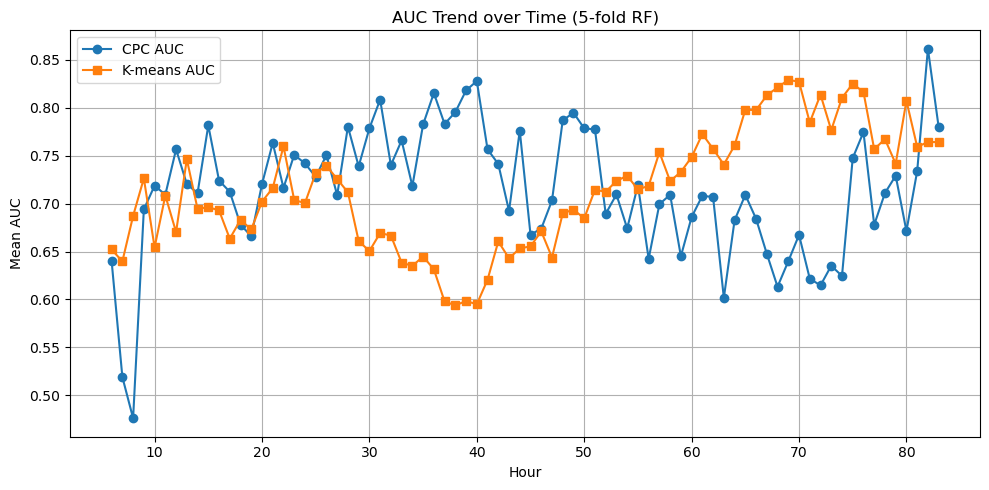

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# ——— Load & clean ———
DATASET = "merged_all_features_clinical.csv"
df_raw = pd.read_csv(DATASET)
df_raw.dropna(axis=0, inplace=True)

# ——— Define feature columns ———
drop_feats = ['pat_ID', 'cluster', 'cpc', 'hour', 'age', 'sex', 'vfib']
feature_columns = [c for c in df_raw.columns if c not in drop_feats]
meta_columns = ['pat_ID', 'hour', 'cpc', 'cluster']
df_samples = df_raw[meta_columns + feature_columns].copy()

# ——— Global hyperparameter search ———
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Best parameters for CPC (binary classification)
rf_base = RandomForestClassifier(random_state=42)
grid_cpc = GridSearchCV(
    rf_base, param_grid, cv=5,
    scoring='roc_auc', n_jobs=-1
)
grid_cpc.fit(df_samples[feature_columns], df_samples['cpc'])
best_params_cpc = grid_cpc.best_params_
print("Best CPC RF params:", best_params_cpc)

# Best parameters for K-means labels (multi-class)
grid_km = GridSearchCV(
    rf_base, param_grid, cv=5,
    scoring='roc_auc_ovr', n_jobs=-1
)
grid_km.fit(df_samples[feature_columns], df_samples['cluster'])
best_params_km = grid_km.best_params_
print("Best K-means RF params:", best_params_km)

# === Model builders ===
def make_model_cpc():
    return RandomForestClassifier(**best_params_cpc, random_state=42)

def make_model_km():
    return RandomForestClassifier(**best_params_km, random_state=42)

# === Utility functions ===
def can_split(y, n_splits):
    counts = pd.Series(y).value_counts()
    return len(counts) >= 2 and (counts.min() >= n_splits)

def safe_roc_auc_score(y_true, y_score, **kwargs):
    try:
        return roc_auc_score(y_true, y_score, **kwargs)
    except ValueError:
        return np.nan

# === Load cleaned data ===
DATASET = "merged_all_features_clinical.csv"
df_samples = pd.read_csv(DATASET).dropna()

# Define feature set
drop_feats = ['pat_ID', 'cluster', 'cpc', 'hour', 'age', 'sex', 'vfib']
feature_columns = [c for c in df_samples.columns if c not in drop_feats]

# === Evaluate at each hour ===
hours = sorted(df_samples['hour'].unique())
results = []

for h in hours:
    df_h = df_samples[df_samples['hour'] == h]
    X = df_h[feature_columns].values

    # Binary transformation of CPC
    def map_cpc_binary(x):
        return 1 if x in [1, 2] else 0

    y_cpc = df_h['cpc'].apply(map_cpc_binary).values
    y_km = df_h['cluster'].values

    if len(df_h) < 20 or not can_split(y_cpc, 5) or not can_split(y_km, 5):
        print(f"Skipping hour {h}: too few samples or class imbalance.")
        continue

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs_cpc, accs_cpc = [], []
    aucs_km, accs_km = [], []

    for tr, te in cv.split(X, y_cpc):
        X_tr, X_te = X[tr], X[te]
        ytr_c, yte_c = y_cpc[tr], y_cpc[te]
        ytr_k, yte_k = y_km[tr], y_km[te]

        # --- CPC ---
        m_c = make_model_cpc()
        m_c.fit(X_tr, ytr_c)
        prob_c = m_c.predict_proba(X_te)[:, 1]
        aucs_cpc.append(safe_roc_auc_score(yte_c, prob_c))
        accs_cpc.append(accuracy_score(yte_c, m_c.predict(X_te)))

        # --- K-means ---
        m_k = make_model_km()
        m_k.fit(X_tr, ytr_k)
        prob_k = m_k.predict_proba(X_te)
        if prob_k.shape[1] == 2:
            aucs_km.append(safe_roc_auc_score(yte_k, prob_k[:, 1]))
        else:
            aucs_km.append(safe_roc_auc_score(
                yte_k, prob_k, multi_class='ovr', average='macro'
            ))
        accs_km.append(accuracy_score(yte_k, m_k.predict(X_te)))

    results.append({
        'hour': h,
        'n_samples': len(df_h),
        'cpc_auc': np.nanmean(aucs_cpc),
        'cpc_acc': np.nanmean(accs_cpc),
        'km_auc': np.nanmean(aucs_km),
        'km_acc': np.nanmean(accs_km),
    })

# === Output results ===
df_results = pd.DataFrame(results)
print(df_results)

# Optionally save
df_results.to_csv("hourly_rf_optimized_results.csv", index=False)

# === Plotting ===
plt.figure(figsize=(10, 5))
plt.plot(df_results['hour'], df_results['cpc_auc'], label='CPC AUC', marker='o')
plt.plot(df_results['hour'], df_results['km_auc'], label='K-means AUC', marker='s')
plt.xlabel('Hour')
plt.ylabel('Mean AUC')
plt.title('AUC Trend over Time (5-fold RF)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### Xgboost

C:\Users\admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:26:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost CPC params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


C:\Users\admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost KM params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}


C:\Users\admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

    hour  n_samples   cpc_auc   cpc_acc    km_auc    km_acc
0      6         52  0.538095  0.590909  0.603395  0.381818
1      7         59  0.446528  0.660606  0.623807  0.525758
2      8         68  0.396364  0.647253  0.680514  0.515385
3      9         73  0.655051  0.711429  0.702938  0.495238
4     10         80  0.703205  0.700000  0.542840  0.475000
..   ...        ...       ...       ...       ...       ...
73    79        109  0.612719  0.806926  0.668572  0.494372
74    80        107  0.703216  0.822078  0.790529  0.654978
75    81        106  0.722222  0.858442  0.749543  0.558009
76    82        105  0.791394  0.828571  0.750292  0.561905
77    83        105  0.806536  0.800000  0.714893  0.561905

[78 rows x 6 columns]


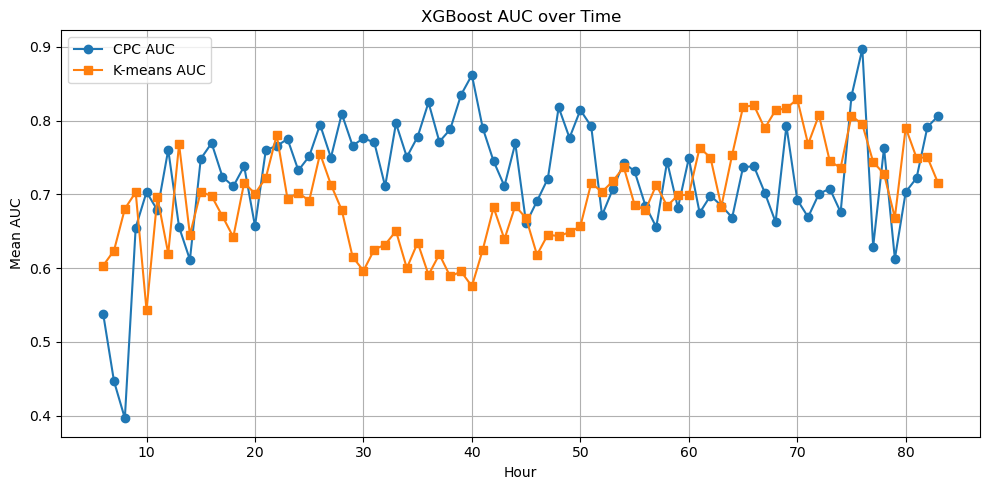

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

# ========== Load and clean data ==========
DATASET = "merged_all_features_clinical.csv"
df_raw = pd.read_csv(DATASET)
df_raw.dropna(axis=0, inplace=True)

# ========== Define feature columns ==========
drop_feats = ['pat_ID', 'cluster', 'cpc', 'hour', 'age', 'sex', 'vfib']
feature_columns = [c for c in df_raw.columns if c not in drop_feats]
meta_columns = ['pat_ID', 'hour', 'cpc', 'cluster']
df_samples = df_raw[meta_columns + feature_columns].copy()

# ========== Hyperparameter search (XGBoost) ==========
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# CPC (binary classification)
grid_cpc = GridSearchCV(
    xgb_base, param_grid, cv=5,
    scoring='roc_auc', n_jobs=-1
)
grid_cpc.fit(df_samples[feature_columns], df_samples['cpc'].apply(lambda x: 1 if x in [1, 2] else 0))
best_params_cpc = grid_cpc.best_params_
print("Best XGBoost CPC params:", best_params_cpc)

# K-means (multi-class classification)
grid_km = GridSearchCV(
    xgb_base, param_grid, cv=5,
    scoring='roc_auc_ovr', n_jobs=-1
)
grid_km.fit(df_samples[feature_columns], df_samples['cluster'])
best_params_km = grid_km.best_params_
print("Best XGBoost KM params:", best_params_km)

# ========== Model factory functions ==========
def make_model_cpc():
    return XGBClassifier(**best_params_cpc, use_label_encoder=False, eval_metric='logloss', random_state=42)

def make_model_km():
    return XGBClassifier(**best_params_km, use_label_encoder=False, eval_metric='logloss', random_state=42)

# ========== Utility functions ==========
def can_split(y, n_splits):
    counts = pd.Series(y).value_counts()
    return len(counts) >= 2 and (counts.min() >= n_splits)

def safe_roc_auc_score(y_true, y_score, **kwargs):
    try:
        return roc_auc_score(y_true, y_score, **kwargs)
    except ValueError:
        return np.nan

# ========== Per-hour evaluation ==========
df_samples = pd.read_csv(DATASET).dropna()
feature_columns = [c for c in df_samples.columns if c not in drop_feats]
hours = sorted(df_samples['hour'].unique())
results = []

for h in hours:
    df_h = df_samples[df_samples['hour'] == h]
    X = df_h[feature_columns].values
    y_cpc = df_h['cpc'].apply(lambda x: 1 if x in [1, 2] else 0).values
    y_km = df_h['cluster'].values

    if len(df_h) < 20 or not can_split(y_cpc, 5) or not can_split(y_km, 5):
        print(f"Skipping hour {h}: too few samples or class imbalance.")
        continue

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs_cpc, accs_cpc = [], []
    aucs_km, accs_km = [], []

    for tr, te in cv.split(X, y_cpc):
        X_tr, X_te = X[tr], X[te]
        ytr_c, yte_c = y_cpc[tr], y_cpc[te]
        ytr_k, yte_k = y_km[tr], y_km[te]

        # CPC model
        m_c = make_model_cpc()
        m_c.fit(X_tr, ytr_c)
        prob_c = m_c.predict_proba(X_te)[:, 1]
        aucs_cpc.append(safe_roc_auc_score(yte_c, prob_c))
        accs_cpc.append(accuracy_score(yte_c, m_c.predict(X_te)))

        # K-means model
        m_k = make_model_km()
        m_k.fit(X_tr, ytr_k)
        prob_k = m_k.predict_proba(X_te)
        if prob_k.shape[1] == 2:
            aucs_km.append(safe_roc_auc_score(yte_k, prob_k[:, 1]))
        else:
            aucs_km.append(safe_roc_auc_score(yte_k, prob_k, multi_class='ovr', average='macro'))
        accs_km.append(accuracy_score(yte_k, m_k.predict(X_te)))

    results.append({
        'hour': h,
        'n_samples': len(df_h),
        'cpc_auc': np.nanmean(aucs_cpc),
        'cpc_acc': np.nanmean(accs_cpc),
        'km_auc': np.nanmean(aucs_km),
        'km_acc': np.nanmean(accs_km),
    })

df_results = pd.DataFrame(results)
print(df_results)
df_results.to_csv("hourly_xgboost_results.csv", index=False)  # Optional: save results

# ========== Plotting ==========
plt.figure(figsize=(10, 5))
plt.plot(df_results['hour'], df_results['cpc_auc'], label='CPC AUC', marker='o')
plt.plot(df_results['hour'], df_results['km_auc'], label='K-means AUC', marker='s')
plt.xlabel('Hour')
plt.ylabel('Mean AUC')
plt.title('XGBoost AUC over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### Hourly LSTM

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import SMOTE

# ——— Hyperparameters ———
BATCH_SIZE    = 64
LR            = 1e-3
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS_SEARCH = 5
EPOCHS_FINAL  = 50
SEQ_LEN       = 1

# ——— 1) Load dataset ———
DATASET = "merged_all_features_clinical.csv"
df_raw = pd.read_csv(DATASET).dropna(axis=0)

# ——— 2) Feature selection ———
drop_feats = ['pat_ID','cluster','cpc','hour','age','sex','vfib']
all_features = [c for c in df_raw.columns if c not in drop_feats]
meta_columns = ['pat_ID','hour','cpc','cluster']

rf_cpc = RandomForestClassifier(
    n_estimators=500, max_depth=10,
    min_samples_split=5, min_samples_leaf=1,
    random_state=42
)
rf_cpc.fit(df_raw[all_features], df_raw['cpc'])
importances = rf_cpc.feature_importances_
top50_features = [all_features[i] for i in np.argsort(importances)[::-1][:50]]

# ——— 3) Build final DataFrame ———
df = df_raw[meta_columns + top50_features].copy()
df['cpc_label'] = df['cpc'].apply(lambda x: 1 if x in [1,2] else 0).astype(int)

# Optionally convert K-means cluster labels to binary labels
binary_labels = True  # Set to True to enable this
if binary_labels:
    # 1) Patient-level table with cpc and cluster
    pat_df = (
        df[['pat_ID', 'cpc', 'cluster']]
        .drop_duplicates(subset='pat_ID')
        .copy()
    )
    pat_df['cpc'] = pd.to_numeric(pat_df['cpc'], errors='coerce')

    # 2) Flag good outcome
    pat_df['is_good'] = pat_df['cpc'].isin([1, 2])

    # 3) Compute good outcome ratio in each cluster
    cluster_ratios = pat_df.groupby('cluster')['is_good'].mean()

    # 4) Find two clusters with lowest good outcome ratio
    poor_clusters = cluster_ratios.nsmallest(2).index.tolist()

    # 5) Generate binary cluster label
    pat_df['binary_cluster'] = pat_df['cluster'].apply(lambda cl: 0 if cl in poor_clusters else 1)

    # 6) Merge back and assign as km_label
    df = df.merge(pat_df[['pat_ID', 'binary_cluster']], on='pat_ID', how='left')
    df['km_label'] = df['binary_cluster'].astype(int)
else:
    df['km_label'] = df['cluster'].astype(int)

# ——— 4) Normalize features ———
scaler = StandardScaler()
X_all = scaler.fit_transform(df[top50_features])
X_all = X_all.reshape(-1, SEQ_LEN, X_all.shape[1])
y_cpc_all = df['cpc_label'].values
y_km_all  = df['km_label'].values

# ——— 5) Define LSTM model ———
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, bidirectional, dropout, out_dim):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        directions = 2 if bidirectional else 1
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * directions, out_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        h = self.dropout(h)
        return self.fc(h)

In [4]:
# ——— 6) Hyperparameter search (CPC) ———
param_grid = {
    'hidden_size': [64, 128, 256],
    'num_layers': [1, 2],
    'dropout': [0.2, 0.5],
    'bidirectional': [False, True]
}
best_auc = 0.0
best_params = {}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for hs in param_grid['hidden_size']:
    for nl in param_grid['num_layers']:
        for dr in param_grid['dropout']:
            for bd in param_grid['bidirectional']:
                aucs = []
                for tr_idx, te_idx in skf.split(X_all, y_cpc_all):
                    model = LSTMClassifier(
                        input_dim=X_all.shape[2],
                        hidden_size=hs,
                        num_layers=nl,
                        bidirectional=bd,
                        dropout=dr,
                        out_dim=1
                    ).to(DEVICE)
                    opt = optim.Adam(model.parameters(), lr=LR)
                    crit = nn.BCEWithLogitsLoss()
                    model.train()
                    for _ in range(EPOCHS_SEARCH):
                        for xb, yb in DataLoader(
                            TensorDataset(
                                torch.tensor(X_all[tr_idx], dtype=torch.float32),
                                torch.tensor(y_cpc_all[tr_idx], dtype=torch.float32)
                            ),
                            batch_size=BATCH_SIZE, shuffle=True
                        ):
                            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                            loss = crit(model(xb).squeeze(1), yb)
                            opt.zero_grad(); loss.backward(); opt.step()

                    model.eval()
                    with torch.no_grad():
                        probs = torch.sigmoid(
                            model(torch.tensor(X_all[te_idx], dtype=torch.float32).to(DEVICE)).squeeze(1)
                        ).cpu().numpy()
                    aucs.append(roc_auc_score(y_cpc_all[te_idx], probs))

                mean_auc = np.mean(aucs)
                if mean_auc > best_auc:
                    best_auc = mean_auc
                    best_params = dict(
                        hidden_size=hs,
                        num_layers=nl,
                        dropout=dr,
                        bidirectional=bd
                    )
print("Best LSTM params:", best_params, "AUC =", best_auc)

Best LSTM params: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'bidirectional': True} AUC = 0.9196942788055683


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid f

    hour  n_samples   cpc_auc   cpc_acc    km_auc    km_acc
0      6         52  0.767857  0.561818  0.614048  0.540000
1      7         59  0.696991  0.522727  0.772606  0.656061
2      8         68  0.706061  0.465934  0.707601  0.516484
3      9         73  0.755556  0.754286  0.762692  0.661905
4     10         80  0.843590  0.725000  0.743474  0.550000
..   ...        ...       ...       ...       ...       ...
73    79        109  0.780068  0.651948  0.831327  0.706061
74    80        107  0.783431  0.598701  0.826498  0.709524
75    81        106  0.802778  0.595238  0.800128  0.726407
76    82        105  0.843900  0.704762  0.786084  0.666667
77    83        105  0.847821  0.685714  0.754437  0.647619

[78 rows x 6 columns]
Saved predictions_per_fold.csv with 11753 records.


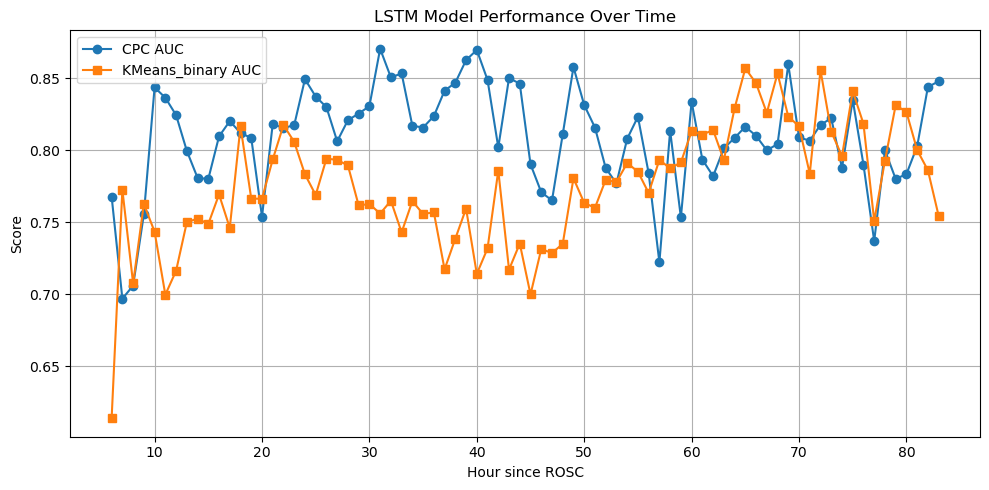

In [5]:
results, pred_records = [], []
for h in sorted(df['hour'].unique()):
    df_h = df[df['hour'] == h].reset_index(drop=True)
    if len(df_h) < 30 or df_h['cpc_label'].nunique() < 2:
        continue

    X_h = scaler.transform(df_h[top50_features].values).reshape(-1, SEQ_LEN, len(top50_features))
    y_c, y_k = df_h['cpc_label'].values, df_h['km_label'].values
    skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs_c, accs_c, aucs_k, accs_k = [], [], [], []

    for tr, te in skf5.split(X_h, y_c):
        # Setup test data
        X_te = torch.tensor(X_h[te], dtype=torch.float32).to(DEVICE)
        y_te_c = torch.tensor(y_c[te], dtype=torch.float32)
        y_te_k = torch.tensor(y_k[te], dtype=torch.long)

        # SMOTE for CPC
        X_c_flat = X_h[tr][:, 0, :]
        y_c_tr = y_c[tr]
        X_c_bal, y_c_bal = SMOTE(random_state=42).fit_resample(X_c_flat, y_c_tr)
        X_c_bal = X_c_bal.reshape(-1, 1, X_c_bal.shape[1])

        # Train CPC model
        m_c = LSTMClassifier(input_dim=X_h.shape[2], out_dim=1, **best_params).to(DEVICE)
        opt_c = optim.Adam(m_c.parameters(), lr=LR)
        crit_c = nn.BCEWithLogitsLoss()
        best_auc_c, best_probs_c, best_preds_c = 0.0, None, None

        for _ in range(EPOCHS_FINAL):
            m_c.train()
            for xb, yb in DataLoader(
                TensorDataset(torch.tensor(X_c_bal, dtype=torch.float32),
                              torch.tensor(y_c_bal, dtype=torch.float32)),
                batch_size=BATCH_SIZE, shuffle=True
            ):
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                loss = crit_c(m_c(xb).squeeze(1), yb)
                opt_c.zero_grad(); loss.backward(); opt_c.step()

            m_c.eval()
            with torch.no_grad():
                probs_tmp = torch.sigmoid(m_c(X_te).squeeze(1)).cpu().numpy()
                auc_tmp = roc_auc_score(y_te_c.numpy(), probs_tmp)
                if auc_tmp > best_auc_c:
                    best_auc_c = auc_tmp
                    best_probs_c = probs_tmp.copy()
                    best_preds_c = (best_probs_c > 0.5).astype(int)

        probs_c, preds_c = best_probs_c, best_preds_c

        # Train KMeans model
        y_k_tr = y_k[tr]
        class_counts = np.bincount(y_k_tr)
        class_weights = 1.0 / class_counts
        class_weights *= len(class_counts) / class_weights.sum()
        weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

        is_binary_km = len(np.unique(y_k)) == 2
        out_dim_k = 1 if is_binary_km else len(np.unique(y_k))
        m_k = LSTMClassifier(input_dim=X_h.shape[2], out_dim=out_dim_k, **best_params).to(DEVICE)
        opt_k = optim.Adam(m_k.parameters(), lr=LR)
        crit_k = (
            nn.BCEWithLogitsLoss()
            if is_binary_km
            else nn.CrossEntropyLoss(weight=weight_tensor)
        )
        best_auc_k, best_probs_k, best_preds_k = 0.0, None, None

        for _ in range(EPOCHS_FINAL):
            m_k.train()
            for xb, yb in DataLoader(
                TensorDataset(torch.tensor(X_h[tr], dtype=torch.float32),
                              torch.tensor(y_k_tr, dtype=torch.long)),
                batch_size=BATCH_SIZE, shuffle=True
            ):
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = m_k(xb)
                if is_binary_km:
                    loss = crit_k(logits.squeeze(1), yb.float())
                else:
                    loss = crit_k(logits, yb)
                opt_k.zero_grad(); loss.backward(); opt_k.step()

            m_k.eval()
            with torch.no_grad():
                logits_tmp = m_k(X_te)
                if is_binary_km:
                    probs_tmp = torch.sigmoid(logits_tmp.squeeze(1)).cpu().numpy()
                    preds_tmp = (probs_tmp > 0.5).astype(int)
                    auc_tmp = roc_auc_score(y_te_k.numpy(), probs_tmp)
                else:
                    probs_tmp = torch.softmax(logits_tmp, dim=1).cpu().numpy()
                    preds_tmp = probs_tmp.argmax(axis=1)
                    try:
                        auc_tmp = roc_auc_score(
                           y_te_k.numpy(),
                           probs_tmp,
                           multi_class='ovr',
                           average='macro'
                       )
                    except ValueError:
                        auc_tmp = -1.0
                if auc_tmp > best_auc_k:
                    best_auc_k = auc_tmp
                    best_probs_k = probs_tmp.copy()
                    best_preds_k = preds_tmp.copy()

        if best_preds_k is None:
            preds_k = preds_tmp
            probs_k = probs_tmp
        else:
           probs_k, preds_k = best_probs_k, best_preds_k
        
            

        for i, gidx in enumerate(te):
            pred_records.append({
                'pat_ID': df_h.loc[gidx, 'pat_ID'],
                'hour': df_h.loc[gidx, 'hour'],
                'true_cpc': y_c[gidx],
                'pred_cpc': int(preds_c[i]),
                'true_km': y_k[gidx],
                'pred_km': int(preds_k[i])
            })

        aucs_c.append(roc_auc_score(y_c[te], probs_c))
        accs_c.append(accuracy_score(y_c[te], preds_c))
        if is_binary_km:
            auc_k = roc_auc_score(y_k[te], probs_k)
        else:
            try:
                auc_k = roc_auc_score(
                    y_k[te],
                    probs_k,
                    multi_class='ovr',
                    average='macro'
                )
            except ValueError:
                auc_k = np.nan
            
        aucs_k.append(auc_k)
        accs_k.append(accuracy_score(y_k[te], preds_k))

    results.append({
        'hour': h,
        'n_samples': len(df_h),
        'cpc_auc': np.mean(aucs_c),
        'cpc_acc': np.mean(accs_c),
        'km_auc': np.mean(aucs_k),
        'km_acc': np.mean(accs_k)
    })

df_res = pd.DataFrame(results)
df_res.to_csv("hourly_lstm_results.csv", index=False)
df_preds = pd.DataFrame(pred_records)
df_preds.to_csv("predictions_per_fold.csv", index=False)
print(df_res)
print("Saved predictions_per_fold.csv with", len(df_preds), "records.")

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("hourly_lstm_results.csv")


plt.figure(figsize=(10, 5))


plt.plot(df['hour'], df['cpc_auc'], label='CPC AUC', marker='o')
plt.plot(df['hour'], df['km_auc'], label='KMeans_binary AUC', marker='s')


plt.xlabel("Hour since ROSC")
plt.ylabel("Score")
plt.title("LSTM Model Performance Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()


plt.show()

